# <br><br><span style="color:rebeccapurple">Overview of machine learning</span>

Two most common types of machine learning

1. Supervised learning
 - Data are labelled, i.e., input-output pairs
 - Goal: making "good" predictions
 - Obvious error metric/loss function where we can compare predictions with observations
 - Example: linear regression (continuous output) and logistic regression (discrete output)


2. Unsupervised learning
 - Data are not labelled, i.e., no output
 - Goal: finding interesting pattern/knowledge discovery
 - No obvious error metric
 - Example: clustering
 
Two main types of models

1. Parametric models
 - Make strong assumptions about data (normally distributed, etc.)
 - Learn and use fixed number of parameters
 - Example: linear model
 
 
2. Nonparametric models
 - Make fewer assumptions about data (no asummed distribution)
 - Learn and use a flexible number of parameters
 - Example: decision tree


# <br><br><span style="color:rebeccapurple">Linear regression</span>

Linear regression model is typically
$$
\begin{align}
y = \beta_0 + \sum_{i=1}^N \beta_i x_i
\end{align}
$$
where $y$ is the output, $x_i$ are the predictors and $N$ is the number of predictors. What we want to learn is the set of parameters, or weights, $\beta_i, i=0,...N$.

To learn these parameters, sklearn will minimize there sidual sum of squares
$$
RSS = (y_{pred} - y_{obs})^2 = (\beta_0 + \sum_{i=1}^N \beta_i x_i - y_{obs})^2
$$
where $M$ is the number of observations.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [95]:
## Import data
df = pd.read_csv('datasets/fish.csv')
df.head()

,species,vertical_len,diag_len,cross_len,height,width,weight
0,Bream,23.2,25.4,30.0,11.5200,4.0200,242.0
1,Bream,24.0,26.3,31.2,12.4800,4.3056,290.0
2,Bream,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Bream,26.3,29.0,33.5,12.7300,4.4555,363.0
4,Bream,26.5,29.0,34.0,12.4440,5.1340,430.0


Suppose we want to predict the weight (in log space) of a fish. We will build a model with the remaining features as predictors. 

In [283]:
# Get the feature columns for easier access
feature_names = df.columns.values[:-1]
feature_names 

array(['species', 'vertical_len', 'diag_len', 'cross_len', 'height',
       'width'], dtype=object)

In [284]:
# Split the dataset into predictors and response
X = df[feature_names]
Y = np.log(df['weight'])

## <br><span style="color:teal"> Split samples into train and test dataset

An important aspect of machine learning that sets it apart from fields like optimization is that in addition to minimizing training error, we want to minimize the generalization error. In other words, we want to make sure that the trained model generalizes well to unobserved/future inputs. That is why we need to split our dataset into train and test set.
    
These 2 sets should be disjoint, i.e., one instance shouldn't be in both sets. (When dataset is too small, there are special measures but we will not cover here.)
    
The typical split is 80%-20% for train vs test set. In sklearn it is default to 75-25 (or more accurately 0.75-0.25). 
    
The train dataset is used to learn the model's parameters.
The test dataset is used to estimate generalization error. 


In [285]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [286]:
X_train.describe(include='all')

,species,vertical_len,diag_len,cross_len,height,width
count,126,126.000000,126.000000,126.000000,126.000000,126.000000
unique,7,NaN,NaN,NaN,NaN,NaN
top,Perch,NaN,NaN,NaN,NaN,NaN
freq,45,NaN,NaN,NaN,NaN,NaN
mean,NaN,25.596032,27.717460,30.501587,8.831752,4.315787
std,NaN,9.668046,10.377037,11.326288,4.420481,1.706681
min,NaN,7.500000,8.400000,8.800000,1.728400,1.148400
25%,NaN,19.000000,21.000000,22.575000,5.731975,3.335100
50%,NaN,24.550000,26.500000,29.150000,7.469800,4.181100
75%,NaN,32.325000,35.000000,39.450000,12.266550,5.284075


We can see that our training dataset includes 1 categorical variable and 5 numerical variables. We will need to do some preprocessing, specifically one hot encoding and standardization. 

We can follow the procedure laid out in the preprocessing module. 

Important note: preprocessing should be fit to train dataset, instead of applying to the whole set, to avoid leakage of information. Data leakage during preprocessing will create bias toward the test set, potentially leading to a deceptively good generalization result. 

After the preprocessor learns to fit to and transform the train dataset, it is then used to fit (only) to the test set. More specifically, in the case of standardization,the preprocessor will obtain the mean and standard deviation of the train set and use those statistics to transform the test set. As a result, after the transformation, the train set will definitely have 0 mean and unit standard deviation but the test set may not. 

In [287]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[['height']])
train_scaled = scaler.transform(X_train[['height']])
np.mean(train_scaled)

8.414785623150988e-17

In [288]:
test_scaled = scaler.transform(X_test[['height']])
np.mean(test_scaled)

0.17386194582393663

## <br><span style="color:teal"> Create pipelines
    
We can manually apply all the transformations presented in the previous module but sklearn has a convenient feature called Pipeline, which chains all estimators.

Typically, all estimators in a pipeline, except the last one, will be used to preprocess the data and must be transformers (i.e. must have a transform method). The last estimator can be any type and will typically be used for the main purpose like linear regression or classification.
    
Pipeline also helps safeguard against data leakage because it automatically ensures that only train set is used for 

In [289]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [290]:
# Create a pipeline to apply one hot encoder to categorical variable species
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())]) #(chosen_name, transformer)

### <br><span style="color:blue"> Practice

Create a pipeline to apply standard scaler to numerical variables

In [291]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

Now we want to combine these different pipeline and assign them to the right attributes (or columns) of the data.

The sklearn class ColumnTransformer helps us do exactly that.

In [292]:
from sklearn.compose import ColumnTransformer
categorical_columns = ['species']
numerical_columns = feature_names[1:]  

# Create preprocessor pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns), #(chosen_name, Pipeline, columns_to_apply_to)
        ('cat', categorical_transformer, categorical_columns)])

Now that we have our complex preprocessor pipeline, we can create a full model with a preprocessor step and a linear regression step.

In [326]:
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [294]:
# We can take a look at the workflow
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['vertical_len', 'diag_len', 'cross_len', 'height', 'width'],
      dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['species'])])),
                ('regressor', LinearRegression())])

## <br><span style="color:teal"> Fit model to data/learn weights

We don't need a transform step here for the preprocessor because sklearn already do that behind the scene for the train data.


In [295]:
model.fit(X_train, Y_train);

## <br><span style="color:teal"> Predict using learned models

In [296]:
Y_pred = model.predict(X_test)

[Text(0.5, 0, 'True values'), Text(0, 0.5, 'Model predictions')]

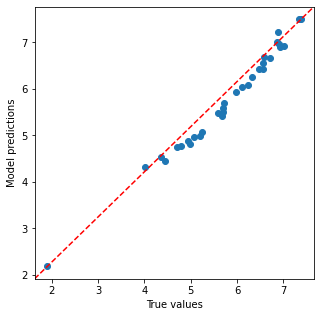

In [297]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(Y_test, Y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
ax.set(xlabel='True values', ylabel='Model predictions')

## <br><span style="color:teal"> Access and interpret learned weights

In [298]:
labels = list(model['preprocessor'].transformers_[0][2]) + list(model['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_columns))

coefs = pd.DataFrame(
    model[1].coef_,
    columns=["Coefficients"],
    index=labels,
)
print(coefs)

                   Coefficients
vertical_len           0.839409
diag_len              -0.519552
cross_len              0.251609
height                 0.276817
width                  0.319873
species_Bream          0.154883
species_Parkki         0.245421
species_Perch          0.139672
species_Pike           0.032522
species_Roach          0.173795
species_Smelt         -1.095344
species_Whitefish      0.349051


In [299]:
# Intercept or bias
model[1].intercept_

5.296093966873676

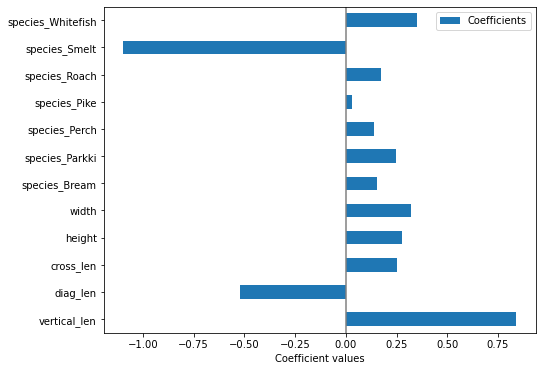

In [300]:
coefs.plot.barh(figsize=(10, 6))
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

From this plot, we can infer that the most important factor in determining weight of a fish is whether it is a smelt and the next important factor is the vertical length of the fish. 

Comparing weight based on their magnitude to determine feature importance can be misleading if features vary widely, i.e., their variances/standard deviations are of different scale. However, we already standardize our dataset and eliminate this concern. Thus, it is relatively safe to make the inference above.

<!-- If coefficients vary significantly when changing the input dataset their robustness is not guaranteed, and they should probably be interpreted with caution. -->

## <br><span style="color:teal"> Evaluate learned model
    
As explained above, we're interested in understanding how well the learned model generalizes. There are several metrics to quantify the quality of a model

A typical measure for regression is the mean squared error
$$
MSE = \frac{1}{M} (y_{pred} - y_{obs})^2
$$

In [142]:
from sklearn.metrics import mean_squared_error

In [143]:
mse = mean_squared_error(Y_test, Y_pred)
print(mse)

0.022032507964441214


Another measure is $R^2$ score, which indicates a goodness of fit. More specifically, it represents the proportion of the response's variance that has been explained by the predictors. Best possible score is 1.

In [146]:
from sklearn.metrics import r2_score

### <br><span style="color:blue"> Practice

Compute the $R^2$ score of the model

In [145]:
r2s = r2_score(Y_test, Y_pred)
print(r2s)

0.9832007220632911


# <br><br><span style="color:rebeccapurple">Homework</span>

### <br><span style="color:blue"> 1. Use a different seed, i.e. changing the random_state argument in train_test_split, and rerun the whole process with this new split. 
    
    Compute the mean squared error of the test set. 
    
    Compare the new weights with the previous results.   

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2022)

### <br><span style="color:blue"> 2. With this same  train-test split, redo the whole process but without using a Pipeline. 
    
    Compute the mean square error of the test set. Is it different from the one you obtained using Pipeline?

In [702]:
## Preprocessing
# Fit to train dataset
x_train = pd.DataFrame()
enc_side = OneHotEncoder().fit(X_train[["species"]])
scaler = StandardScaler().fit(X_train[feature_names[1:]])
scaler_y = StandardScaler().fit(Y_train.values.reshape(-1,1))
# Transform train dataset
x_train[enc_side.categories_[0]] = enc_side.transform(X_train[["species"]]).toarray()
x_train[feature_names[1:]] = scaler.transform(X_train[feature_names[1:]])
y_train = scaler_y.transform(Y_train.values.reshape(-1,1))
y_train = pd.Series(y_train.flatten(), name='weight')

In [703]:
# Transform test dataset
x_test = pd.DataFrame()
x_test[enc_side.categories_[0]] = enc_side.transform(X_test[["species"]]).toarray()
x_test[feature_names[1:]] = scaler.transform(X_test[feature_names[1:]])
y_test = scaler_y.transform(Y_test.values.reshape(-1,1))
y_test = pd.Series(y_test.flatten(), name='weight')

In [750]:
model_manual = LinearRegression()

In [ ]:
# Fit the model to train data
# model_manual.fit()

### <br><span style="color:blue"> 3. Rerun the entire pipeline with raw response values, i.e. not applying log transformation on Y, and see how that affect the model.

In [89]:
# Split the dataset into predictors and response
X = df[feature_names]
Y = df['weight']

In [309]:
# Split data into train-test sets & create pipeline


In [148]:
# Hint: linear regression assumes normal distribution for variables. The plot below may explain the difference. (Run this after you split your data)

# train_dataset = X_train.copy()
# train_dataset.insert(0, "weight", Y_train)
# sns.pairplot(train_dataset, kind="scatter", diag_kind="kde")

### <br><span style="color:blue"> 4. Logistic regression 

In [385]:
df = pd.read_csv('datasets/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,NaN,1.4,0.2,setosa


In [386]:
# Get the feature columns for easier access
feature_names = df.columns.values[:-1]
feature_names 

array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
      dtype=object)

In [387]:
# Split the dataset into predictors and response
X = df[feature_names]
Y = df['target']

In [403]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder().fit(Y)
labels = enc.classes_
Y_num = enc.transform(Y)
labels

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [404]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_num, test_size=0.2, random_state=0)

In [405]:
# Create preprocessor pipeline using ColumnTransformer
from sklearn.impute import SimpleImputer
numeric_transformer = Pipeline(steps=[('nan', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns.values.tolist())])

In [406]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LogisticRegression())])

In [407]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nan',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sepal_length',
                                                   'sepal_width',
                                                   'petal_length',
                                                   'petal_width'])])),
                ('regressor', LogisticRegression())])

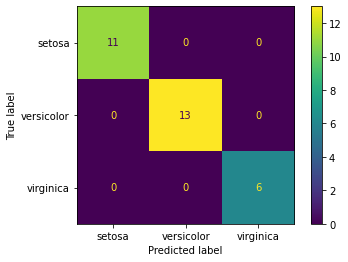

In [409]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()